In [2]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-rt04ve63
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-rt04ve63
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done


In [3]:
import torch
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

In [4]:
# Define dataset paths
import os
DATASET_PATH = "/content/drive/MyDrive/archive/PennFudanPed"
IMAGE_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/archive/PennFudanPed/PNGImages")
MASK_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/archive/PennFudanPed/PedMasks")

In [5]:
def get_penn_fudan_dataset():
    dataset_dicts = []
    image_files = sorted(os.listdir(IMAGE_PATH))
    mask_files = sorted(os.listdir(MASK_PATH))

    for idx, filename in enumerate(image_files):
        record = {}

        image_path = os.path.join(IMAGE_PATH, filename)
        mask_path = os.path.join(MASK_PATH, mask_files[idx])

        height, width = cv2.imread(image_path).shape[:2]

        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        annotations = []
        for contour in contours:
            if len(contour) > 3:
                segmentation = contour.flatten().tolist()
                annotations.append({
                    "segmentation": [segmentation],
                    "bbox": cv2.boundingRect(contour),
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "category_id": 0  # One class: Person
                })

        record["annotations"] = annotations
        dataset_dicts.append(record)

    return dataset_dicts

In [6]:
# Register the dataset
DatasetCatalog.register("penn_fudan", get_penn_fudan_dataset)
MetadataCatalog.get("penn_fudan").set(thing_classes=["person"])

print("✅ Penn-Fudan dataset registered successfully!")

✅ Penn-Fudan dataset registered successfully!


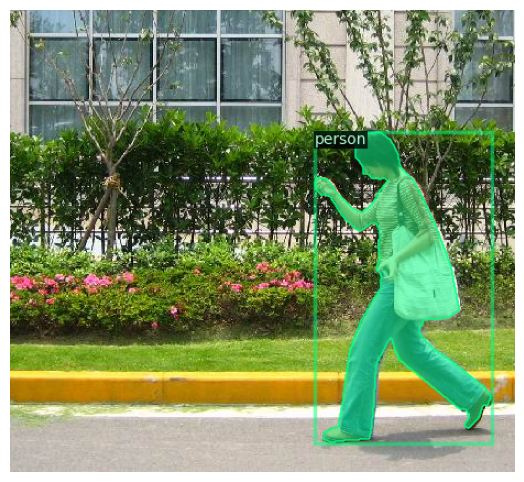

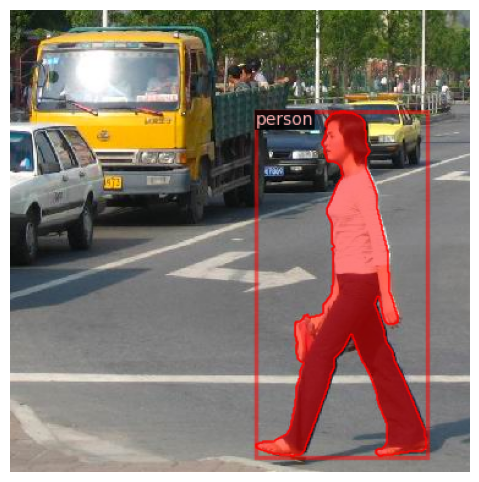

In [7]:
dataset_dicts = get_penn_fudan_dataset()
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("penn_fudan"), scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(8, 6))
    plt.imshow(vis.get_image())
    plt.axis("off")
    plt.show()

In [10]:
!mkdir -p detectron2/configs/COCO-InstanceSegmentation
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml -P detectron2/configs/COCO-InstanceSegmentation/

--2025-01-30 20:48:22--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192 [text/plain]
Saving to: ‘detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’

mask_rcnn_R_50_FPN_ 100%[===================>]     192  --.-KB/s    in 0s      

2025-01-30 20:48:23 (4.06 MB/s) - ‘detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml’ saved [192/192]



In [28]:
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file

cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/model_final.pth"
cfg.DATASETS.TRAIN = ("penn_fudan",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.OUTPUT_DIR = "./output"


[01/30 22:22:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 164MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/30 22:22:28 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/30 22:22:38 d2.utils.events]:  eta: 0:06:56  iter: 19  total_loss: 2.119  loss_cls: 0.6673  loss_box_reg: 0.7402  loss_mask: 0.691  loss_rpn_cls: 0.02695  loss_rpn_loc: 0.0068    time: 0.4295  last_time: 0.4132  data_time: 0.0212  last_data_time: 0.0040   lr: 4.9953e-06  max_mem: 4732M
[01/30 22:22:56 d2.utils.events]:  eta: 0:06:47  iter: 39  total_loss: 2.076  loss_cls: 0.6282  loss_box_reg: 0.7138  loss_mask: 0.6864  loss_rpn_cls: 0.02052  loss_rpn_loc: 0.01041    time: 0.4196  last_time: 0.4612  data_time: 0.0057  last_data_time: 0.0081   lr: 9.9902e-06  max_mem: 4732M
[01/30 22:23:04 d2.utils.events]:  eta: 0:06:45  iter: 59  total_loss: 1.985  loss_cls: 0.5627  loss_box_reg: 0.677  loss_mask: 0.6766  loss_rpn_cls: 0.01767  loss_rpn_loc: 0.007223    time: 0.4237  last_time: 0.4204  data_time: 0.0097  last_data_time: 0.0064   lr: 1.4985e-05  max_mem: 4732M
[01/30 22:23:12 d2.utils.events]:  eta: 0:06:20  iter: 79  total_loss: 1.873  loss_cls: 0.4935  loss_box_reg: 0.6752  loss_

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

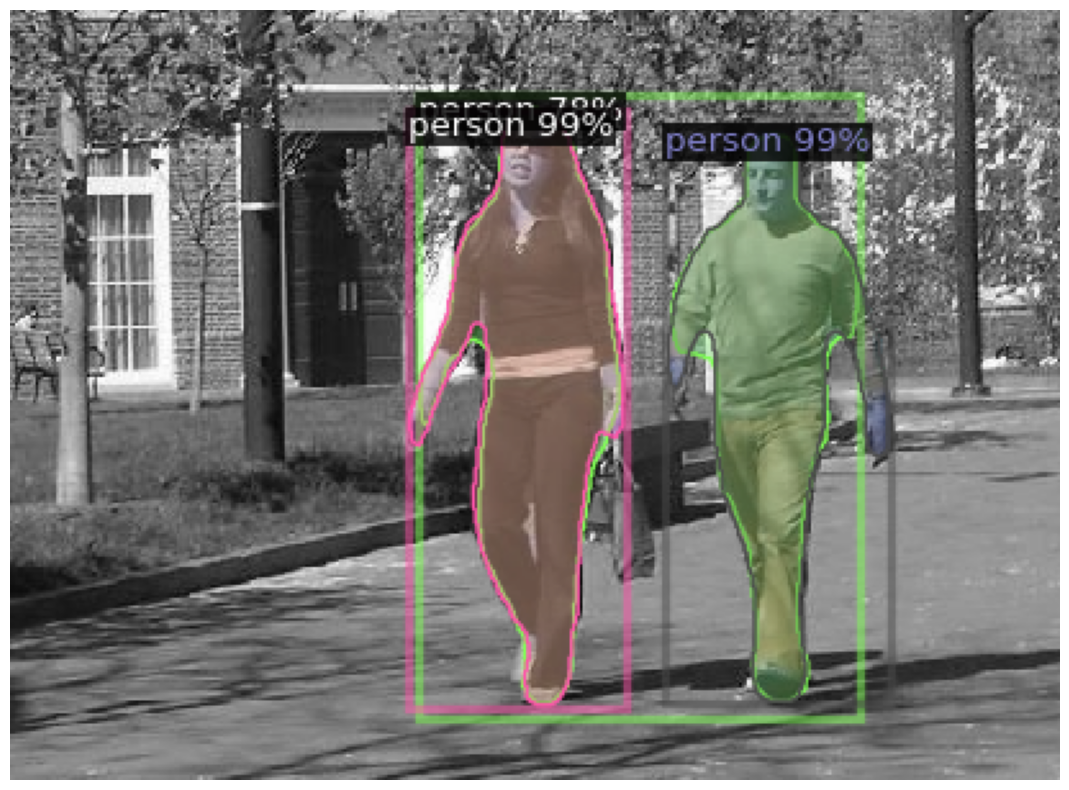

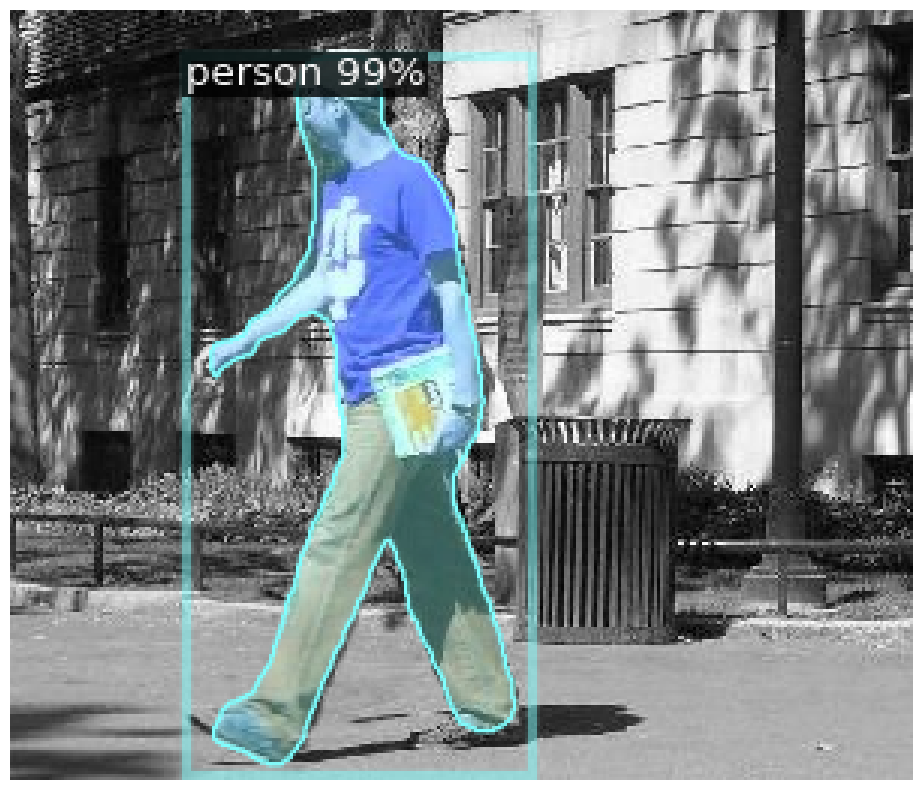

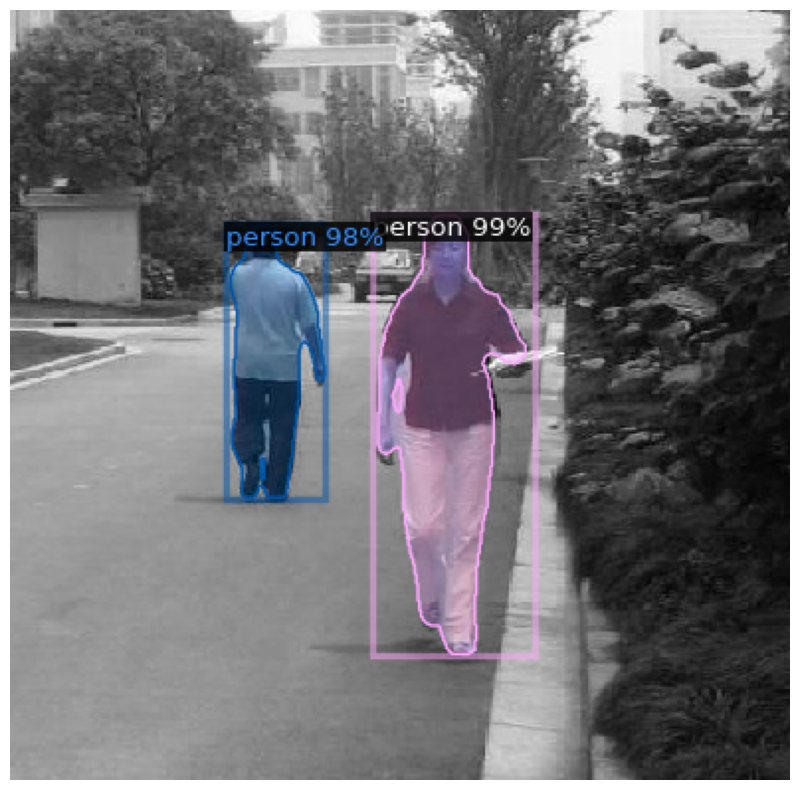

In [75]:

# 1. **Dataset Preparation**
# 2. **Model Configuration**
# 3. **Training**
# 4. **Evaluation**
# 5. **Inference**

import os
import cv2
import numpy as np
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

def get_penn_fudan_dicts(img_dir, mask_dir):
    dataset_dicts = []
    for idx, img_name in enumerate(sorted(os.listdir(img_dir))):
        record = {}
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace(".png", "_mask.png"))

        # Load image dimensions
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # Process masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        objs = []
        for contour in contours:
            if len(contour) < 4:
                continue  # Need at least 4 points for polygon

            segmentation = contour.flatten().tolist()
            bbox = cv2.boundingRect(contour)

            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [segmentation],
                "category_id": 0,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Register dataset
DATASET_PATH = "/content/drive/MyDrive/archive/PennFudanPed"
for d in ["train", "val"]:
    DatasetCatalog.register("penn_fudan_" + d, lambda d=d: get_penn_fudan_dicts(
        os.path.join(DATASET_PATH, "PNGImages"),
        os.path.join(DATASET_PATH, "PedMasks")
    ))
    MetadataCatalog.get("penn_fudan_" + d).set(thing_classes=["person"])

metadata = MetadataCatalog.get("penn_fudan_train")


# ## 2. Model Configuration
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("penn_fudan_train",)
cfg.DATASETS.TEST = ("penn_fudan_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only person class
cfg.TEST.EVAL_PERIOD = 200  # Evaluate every 200 iterations

# ## 3. Training with Validation
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)

# Create output directory
os.makedirs("/content/output", exist_ok=True)
cfg.OUTPUT_DIR = "/content/output"

# Start training
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


# ## 4. Evaluation
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# Load best model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Run evaluation
evaluator = COCOEvaluator("penn_fudan_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "penn_fudan_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


# ## 5. Inference & Visualization

from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

def visualize_predictions(cfg, num_samples=3):
    predictor = DefaultPredictor(cfg)
    dataset_dicts = get_penn_fudan_dicts(
        os.path.join(DATASET_PATH, "PNGImages"),
        os.path.join(DATASET_PATH, "PedMasks")
    )

    for d in random.sample(dataset_dicts, num_samples):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)

        v = Visualizer(im[:, :, ::-1],
                       metadata=metadata,
                       scale=0.8,
                       instance_mode=ColorMode.IMAGE_BW)
        instances = outputs["instances"].to("cpu")
        vis = v.draw_instance_predictions(instances)

        plt.figure(figsize=(14, 10))
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

print("\nSample Predictions:")
visualize_predictions(cfg)